<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/preprocessing/UV_Measurement_to_DF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hier werden die Rohdaten des BTS2048-UV-WP in eine nutzbare CSV-Datei geschrieben

**Dokumentenname: UV_Measurement_to_CSV.ipynb**

Es werden die OR0-Daten (NasaAmes-Format), die eigentlich für den Versand an das BFS gedacht sind umgewandelt und in eine CSV-Datei geschrieben. Aufgrund der großen Datenmenge geschieht dies für jeden Monat getrennt.

# Import der benötigten Module:

In [ ]:
# Import der benötigten Module
import os, sys
import glob
import datetime
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt

from scipy.io import netcdf
from datetime import timedelta
from datetime import datetime

from google.colab import drive
from google.colab import files

Zu Beginn muss die Google-Drive eingerichtet werden, in der die Messdaten (OR0-Dateien) gespeichert sind. Danach werden alle verfügbaren Unterordner aufgerufen. So wird geprüft, ob der Mount richtig funktioniert hat.

In [ ]:
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive'
# Durchsuche den Google Drive-Pfad
for root, dirs, files in os.walk(drive_path):
    for dir in dirs:
        # Gib den Namen des Unterordners aus
        # print(os.path.join(root, dir))

**Monat der Exportiert werden soll:**

In [ ]:
month = '23.08'

Danach werden die einzelnen OR0-Dateien (NasaAmes Format) geladen und umgewandelt.

Das NasaAmes Format: https://espoarchive.nasa.gov/content/Ames_Format_Specification_v20

Die Messdaten sind unter dem FFI (File Format Index) 2005 gespeichert. Dieser Standard ist durch die Nasa nicht dokumentiert. Deshalb nachfolgend ein eigener Parser, der die Daten in eine nutzbare CSV umwandelt.

**Beschreibung der einzelnen Dictionaries und deren Inhalt:**

- **file_names** = enthält die Dateinamen der einzelnen OR0-Dateien
- **file_content** = Enthält den Inhalt der OR0-Dateien
- **end_line_header** = enthält die Zeile an dem der Header endet

## Dateien einlesen und vor verarbeiten:

In [ ]:
# Pfad zum Ordner mit den Dateien in Google Drive
folder_path = '/content/drive/MyDrive/Colab_Notebooks/NasaAmes_Messdaten/Data/' + month

# OR0-Dateien im Ordner lesen
file_paths = glob.glob(folder_path + '/*.OR0')

# Liste für die Dateinamen erstellen
file_names = []

# Schleife über die Dateien
for file_path in file_paths:

    if os.path.getsize(file_path) > 100 * 1024:
      # Dateiname extrahieren
      file_name = os.path.splitext(os.path.basename(file_path))[0]

      # Datei öffnen und Inhalt lesen
      with open(file_path, 'r') as file:
          file_content = file.read()

      # Variable für die Datei erstellen
      globals()[file_name] = file_content

      file_names.append(file_name)

**Dataframe mit Wellenlängen erstellen:**
- Dieser wird später genutzt um die Spalten des Dataframe zu benennen.

In [ ]:
def create_df_Wellenlaenge(start, end, step):
    # Erstelle eine Liste mit den gewünschten Werten
    numbers_list = [round(num, 3) for num in list(np.arange(start, end + step, step))]
    # Erstelle den Dataframe
    df = pd.DataFrame({'Wellenlaenge': numbers_list})

    return df

In [ ]:
np_Wellenlaenge = np.round(np.arange(290.0, 420.05, 0.1), decimals = 1)
df_Wellenlaenge = pd.DataFrame({'Wellenlaenge': np_Wellenlaenge})

**String aufteilen in einzelne Zeile schreiben:**

- Zur weitern Verarbeitung müssen alle Elemente als einzelene Strings abgespeichet werden.

In [ ]:
file_content = {}  # Dictionary für die Messungen erstellen

for file_name in file_names:
    file_variables = globals()[file_name]
    file_content[file_name] = file_variables

# Auf Variablen zugreifen und String in Zeilen aufteilen
for file_name, variable in file_content.items():
    file_content[file_name] = file_content[file_name].split('\n')

**Header extrahieren:**

In [ ]:
# Funktion um den Dateiheader zu extrahieren
def perform_action(file_variables, file_names):
    header_dict = {file_name: "" for file_name in file_names}
    end_line_header_fnc = 0

    for file_name, data in file_variables.items():
        for i, line in enumerate(data):
            header_dict[file_name] += line + "\n"
            if line.strip() == "Pyranometer: readout interval [secs]=5":
                end_line_header_fnc = i
                break

    return header_dict, end_line_header_fnc

In [ ]:
file_header, end_line_header = perform_action(file_content, file_names)

**Header aus Datensatz löschen:**

In [ ]:
def remove_header(lines_content, end_line):
    lines_WO_header_fnc = {}
    lines_WO_header_fnc = lines_content.copy()

    for key, value in lines_WO_header_fnc.items():
        del value[:end_line+1]

    return lines_WO_header_fnc

In [ ]:
lines_WO_header = remove_header(file_content, end_line_header)

##Elemente aufteilen:

In [ ]:
def flatten_and_split(input_list):
    result = []
    for sublist in input_list:
        elements = sublist.split()
        result.extend(elements)
    return result

In [ ]:
def process_dict(input_dict):
    processed_dict = {}
    for key, value in input_dict.items():
        processed_value = flatten_and_split(value)
        sublists = []
        sublist = []
        for element in processed_value:
            if element.isdigit() and len(element) == 5:
                if sublist:
                    sublists.append(sublist)
                    sublist = []
            sublist.append(element)
        if sublist:
            sublists.append(sublist)
        processed_dict[key] = sublists
    return processed_dict

In [ ]:
processed_dict = process_dict(lines_WO_header)

**Zeitstempel in Datensatz finden:**

In [ ]:
# Funktion zum finden eines 5 stelligen Integers (= Zeitstempel)
def find_5_digit_integers(input_list):
    result = []
    for sublist in input_list:
        for element in sublist:
            if isinstance(element, str) and element.isdigit() and len(element) == 5:
                result.append(element)
    return result

In [ ]:
# Funktion, die durch das dict iterriert (und die Funktion "find_5_digit_integers" aufruft)
def find_5_digit_integers_in_dict(input_dict):
    result_dict = {}
    for key, value in input_dict.items():
        result_dict[key] = find_5_digit_integers(value)
    return result_dict

In [ ]:
result_dict = find_5_digit_integers_in_dict(processed_dict)

**Dict in Dataframe speichern:**

In [ ]:
# Erstelle eine leere Liste, um die Zeilen für den DataFrame aufzunehmen
data_rows = []
df_rows = pd.DataFrame()
df_Messdaten = pd.DataFrame()

# Iteriere durch das verschachtelte Dictionary und erstelle Zeilen für den DataFrame
for key, value in processed_dict.items():
    for sublist in value:
        data_rows.append([key] + sublist)

# Definiere Spaltennamen für den DataFrame
columns = ['Datum'] + [f'Wert{i}' for i in range(1, len(data_rows[0]))]

# Erstelle den Pandas DataFrame
df_rows = pd.DataFrame(data_rows, columns=columns)
df_Messdaten = df_rows.copy()

**Prüfen, ob der Inhalt des DF korrekt ist:**

In [ ]:
# df_rows

##Konvertieren des DF:

In [ ]:
# Bestimme die Indexposition, ab der die neuen Spaltennamen zugewiesen werden sollen
start_index = 18  # Beginne ab der 18ten Spalte um an die Messdaten zu kommen

new_column_names = []

# Extrahiere die neuen Spaltennamen aus dem zweiten DataFrame
new_column_names = df_Wellenlaenge['Wellenlaenge'].tolist()
print(new_column_names)

# Ändere die Spaltennamen des DataFrames ab der angegebenen Indexposition
for i, new_name in enumerate(new_column_names):
    df_Messdaten.columns.values[start_index + i] = new_name

[290.0, 290.1, 290.2, 290.3, 290.4, 290.5, 290.6, 290.7, 290.8, 290.9, 291.0, 291.1, 291.2, 291.3, 291.4, 291.5, 291.6, 291.7, 291.8, 291.9, 292.0, 292.1, 292.2, 292.3, 292.4, 292.5, 292.6, 292.7, 292.8, 292.9, 293.0, 293.1, 293.2, 293.3, 293.4, 293.5, 293.6, 293.7, 293.8, 293.9, 294.0, 294.1, 294.2, 294.3, 294.4, 294.5, 294.6, 294.7, 294.8, 294.9, 295.0, 295.1, 295.2, 295.3, 295.4, 295.5, 295.6, 295.7, 295.8, 295.9, 296.0, 296.1, 296.2, 296.3, 296.4, 296.5, 296.6, 296.7, 296.8, 296.9, 297.0, 297.1, 297.2, 297.3, 297.4, 297.5, 297.6, 297.7, 297.8, 297.9, 298.0, 298.1, 298.2, 298.3, 298.4, 298.5, 298.6, 298.7, 298.8, 298.9, 299.0, 299.1, 299.2, 299.3, 299.4, 299.5, 299.6, 299.7, 299.8, 299.9, 300.0, 300.1, 300.2, 300.3, 300.4, 300.5, 300.6, 300.7, 300.8, 300.9, 301.0, 301.1, 301.2, 301.3, 301.4, 301.5, 301.6, 301.7, 301.8, 301.9, 302.0, 302.1, 302.2, 302.3, 302.4, 302.5, 302.6, 302.7, 302.8, 302.9, 303.0, 303.1, 303.2, 303.3, 303.4, 303.5, 303.6, 303.7, 303.8, 303.9, 304.0, 304.1, 304.2

In [ ]:
# df_Messdaten

,Datum,Wert1,Wert2,Wert3,Wert4,Wert5,Wert6,Wert7,Wert8,Wert9,...,419.1,419.2,419.3,419.4,419.5,419.6,419.7,419.8,419.9,420.0
0,SA230819,15000,80,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.7441E-03,1.7399E-03,1.7282E-03,1.6978E-03,1.6548E-03,1.6554E-03,1.6477E-03,1.6204E-03,1.6047E-03,1.6123E-03
1,SA230819,15120,65,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.1415E-03,2.1494E-03,2.1384E-03,2.1180E-03,2.0753E-03,2.0450E-03,2.0085E-03,1.9813E-03,1.9929E-03,2.0181E-03
2,SA230819,15240,65,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,2.6852E-03,2.6581E-03,2.6145E-03,2.5968E-03,2.5728E-03,2.5246E-03,2.4878E-03,2.4638E-03,2.4485E-03,2.5056E-03
3,SA230819,15360,80,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,3.3925E-03,3.3505E-03,3.3011E-03,3.2483E-03,3.2028E-03,3.1542E-03,3.0994E-03,3.0887E-03,3.0811E-03,3.1493E-03
4,SA230819,15480,95,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,4.2192E-03,4.1855E-03,4.1270E-03,4.0496E-03,3.9931E-03,3.9469E-03,3.9163E-03,3.9053E-03,3.9016E-03,3.9207E-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,SA230812,66840,87,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.7586E-02,1.7682E-02,1.7446E-02,1.7058E-02,1.6729E-02,1.6530E-02,1.6374E-02,1.6204E-02,1.6187E-02,1.6424E-02
7596,SA230812,66960,91,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.5258E-02,1.5134E-02,1.4999E-02,1.4647E-02,1.4278E-02,1.4005E-02,1.3969E-02,1.3957E-02,1.3976E-02,1.4127E-02
7597,SA230812,67080,99,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.5389E-02,1.5394E-02,1.5163E-02,1.4902E-02,1.4652E-02,1.4441E-02,1.4258E-02,1.4137E-02,1.4156E-02,1.4294E-02
7598,SA230812,67200,99,4.000E-02,9.999E+9,2.000E+00,0.000E+00,999.9,9.999E+9,9.999E+9,...,1.3874E-02,1.3819E-02,1.3631E-02,1.3399E-02,1.3159E-02,1.2953E-02,1.2809E-02,1.2724E-02,1.2695E-02,1.2801E-02


In [ ]:
# Splaten in float umwandeln
for spalte in new_column_names:
    # Konvertiere nur, wenn die Spalte im DataFrame existiert
    if str(spalte) in df_Messdaten.columns:
        df_Messdaten[str(spalte)] = df_Messdaten[str(spalte)].astype(float)

In [ ]:
# Funktion zum Konvertieren des Datumsformats
def convert_date_format(date_str):
    date_str = date_str[2:]  # Entferne das "SA"-Präfix
    date_obj = datetime.strptime(date_str, "%y%m%d")
    return date_obj

In [ ]:
# Wende die Funktion auf die Spalte an
df_Messdaten['Datum'] = df_Messdaten['Datum'].apply(convert_date_format)

## Export und Import:
 !Dataframe muss exportiert und wieder importiert werden, damit die Zeilen ordnungsgemäß gelöscht werden können!

In [ ]:
def save_dataframe_to_drive(dataframe, folder_path, filename):

    # Erstelle den vollen Pfad zur Datei
    full_path = os.path.join(folder_path, filename)

    # Speichere den DataFrame als CSV-Datei auf Google Drive
    dataframe.to_csv(full_path, index=False)

    print(f'Der DataFrame wurde als {filename} in {folder_path} auf Google Drive gespeichert.')

In [ ]:
# Dataframe abspeichern und wieder importieren
folder_path2 = '/content/drive/My Drive/Colab_Notebooks/CSV_Zwischenspeicher/'
save_dataframe_to_drive(df_Messdaten, folder_path2, month)

Der DataFrame wurde als 23.08 in /content/drive/My Drive/Colab_Notebooks/CSV_Zwischenspeicher/ auf Google Drive gespeichert.


In [ ]:
df_Messdaten_drop = pd.DataFrame()
df_drop = pd.DataFrame()
df_drop = pd.read_csv(folder_path2 + month)

## Löschen nicht gebrauchter Spalten:

In [ ]:
spalten_zum_loeschen = df_drop.columns[2:18]  # Index 3 bis Index 19
df_Messdaten_drop = df_drop.drop(spalten_zum_loeschen, axis=1).copy()

In [ ]:
# Umbenennen der Spalte mit dem Zeitstempel
df_Messdaten_drop.rename(columns={'Wert1': 'Messzeitpunkt'}, inplace=True)

In [ ]:
# df_Messdaten_drop

,Datum,Messzeitpunkt,290.0,290.1,290.2,290.3,290.4,290.5,290.6,290.7,...,419.1,419.2,419.3,419.4,419.5,419.6,419.7,419.8,419.9,420.0
0,2023-08-19,15000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001744,0.001740,0.001728,0.001698,0.001655,0.001655,0.001648,0.001620,0.001605,0.001612
1,2023-08-19,15120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002142,0.002149,0.002138,0.002118,0.002075,0.002045,0.002008,0.001981,0.001993,0.002018
2,2023-08-19,15240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002685,0.002658,0.002615,0.002597,0.002573,0.002525,0.002488,0.002464,0.002449,0.002506
3,2023-08-19,15360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003393,0.003351,0.003301,0.003248,0.003203,0.003154,0.003099,0.003089,0.003081,0.003149
4,2023-08-19,15480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004219,0.004185,0.004127,0.004050,0.003993,0.003947,0.003916,0.003905,0.003902,0.003921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,2023-08-12,66840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017586,0.017682,0.017446,0.017058,0.016729,0.016530,0.016374,0.016204,0.016187,0.016424
7596,2023-08-12,66960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015258,0.015134,0.014999,0.014647,0.014278,0.014005,0.013969,0.013957,0.013976,0.014127
7597,2023-08-12,67080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015389,0.015394,0.015163,0.014902,0.014652,0.014441,0.014258,0.014137,0.014156,0.014294
7598,2023-08-12,67200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013874,0.013819,0.013631,0.013399,0.013159,0.012953,0.012809,0.012724,0.012695,0.012801


In [ ]:
# print(df_Messdaten.isnull().sum(), df_Messdaten_drop.isnull().sum())

In [ ]:
df_Messdaten_drop.columns

Index(['Datum', 'Messzeitpunkt', '290.0', '290.1', '290.2', '290.3', '290.4',
       '290.5', '290.6', '290.7',
       ...
       '419.1', '419.2', '419.3', '419.4', '419.5', '419.6', '419.7', '419.8',
       '419.9', '420.0'],
      dtype='object', length=1303)

## Zeitstempel in Uhrzeit decodieren:

Der Zeitstempel ist als Zeit in Sekunden ab Tagesbeginn codiert und wir in eine Uhrzeit umgewandelt.

In [ ]:
def seconds_to_time(seconds):
    # Sicherstellen, dass die Eingabe eine Ganzzahl ist
    if not isinstance(seconds, int):
        raise ValueError("Die Eingabe muss eine Ganzzahl sein")

    # Sicherstellen, dass die Eingabe im Bereich eines Tages liegt
    if seconds < 0 or seconds >= 24*60*60:
        raise ValueError("Die Eingabe muss zwischen 0 und 86399 Sekunden liegen")

    # Erstellen eines datetime.time-Objekts aus den Sekunden
    return (datetime.min + timedelta(seconds=seconds)).time()

Die Splate Uhrzeit gibt es noch nicht und muss noch eingefügt werden.

In [ ]:
df_Messdaten_drop.insert(1, 'Uhrzeit', df_Messdaten_drop['Messzeitpunkt'].apply(seconds_to_time))

In [ ]:
# df_Messdaten_drop

## Splaten umbennen und ordnen
spalte_uhrzeit = pd.to_datetime(df_Messdaten_drop['Wert1'], unit='s').dt.time

print(spalte_uhrzeit)

position = 1
df_Messdaten_drop.insert(position, 'Uhrzeit', spalte_uhrzeit)

spaltenname = 'Messzeitpunkt'
df_Messdaten_drop.rename(columns={'Wert1': spaltenname}, inplace=True)

In [ ]:
# Datum Spalte einfügen
df_Messdaten_drop['Datum'] = pd.to_datetime(df_Messdaten_drop['Datum'], format="%Y-%m-%d").dt.date
# Datetime Spalte einfügen
df_Messdaten_drop['Datetime'] = df_Messdaten_drop.apply(lambda row: datetime.combine(row['Datum'], row['Uhrzeit']), axis=1)

# Datetime Spalte an den Index 0 verschieben
df_Messdaten_drop.insert(0, 'Datetime', df_Messdaten_drop.pop('Datetime'))

In [ ]:
# df_Messdaten_drop

,Datetime,Datum,Uhrzeit,Messzeitpunkt,290.0,290.1,290.2,290.3,290.4,290.5,...,419.1,419.2,419.3,419.4,419.5,419.6,419.7,419.8,419.9,420.0
0,2023-08-19 04:10:00,2023-08-19,04:10:00,15000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001744,0.001740,0.001728,0.001698,0.001655,0.001655,0.001648,0.001620,0.001605,0.001612
1,2023-08-19 04:12:00,2023-08-19,04:12:00,15120,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002142,0.002149,0.002138,0.002118,0.002075,0.002045,0.002008,0.001981,0.001993,0.002018
2,2023-08-19 04:14:00,2023-08-19,04:14:00,15240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002685,0.002658,0.002615,0.002597,0.002573,0.002525,0.002488,0.002464,0.002449,0.002506
3,2023-08-19 04:16:00,2023-08-19,04:16:00,15360,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003393,0.003351,0.003301,0.003248,0.003203,0.003154,0.003099,0.003089,0.003081,0.003149
4,2023-08-19 04:18:00,2023-08-19,04:18:00,15480,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004219,0.004185,0.004127,0.004050,0.003993,0.003947,0.003916,0.003905,0.003902,0.003921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,2023-08-12 18:34:00,2023-08-12,18:34:00,66840,0.0,0.0,0.0,0.0,0.0,0.0,...,0.017586,0.017682,0.017446,0.017058,0.016729,0.016530,0.016374,0.016204,0.016187,0.016424
7596,2023-08-12 18:36:00,2023-08-12,18:36:00,66960,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015258,0.015134,0.014999,0.014647,0.014278,0.014005,0.013969,0.013957,0.013976,0.014127
7597,2023-08-12 18:38:00,2023-08-12,18:38:00,67080,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015389,0.015394,0.015163,0.014902,0.014652,0.014441,0.014258,0.014137,0.014156,0.014294
7598,2023-08-12 18:40:00,2023-08-12,18:40:00,67200,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013874,0.013819,0.013631,0.013399,0.013159,0.012953,0.012809,0.012724,0.012695,0.012801


## Allgemeine Informationen über den Dataframe:

Es gibt ein paar Ausreißer in den Messdaten, die im Folgenden gelöscht werden.

In [ ]:
def finde_max_werte_fuer_alle_spalten(df):
    # Erstellt ein Dictionary, um die maximalen Werte jeder Spalte zu speichern
    max_werte = {}
    id_werte = {}
    # Iteriere über alle Spalten im DataFrame
    for spalte in df.columns:
        # Ignoriere nicht-numerische Spalten
        if pd.api.types.is_numeric_dtype(df[spalte]):
            max_werte[spalte] = df[spalte].max()      # Maximaler Wert
            id_werte[spalte] = df[spalte].idxmax()    # Spalte mit dem höchsten Wert
    return max_werte, id_werte

In [ ]:
threshold = 1 # Messdaten über 1 werden aussotiert
selected_rows = df_Messdaten_drop[df_Messdaten_drop.iloc[:, 4:1305].gt(threshold).any(axis=1)]

In [ ]:
selected_rows

,Datetime,Datum,Uhrzeit,Messzeitpunkt,290.0,290.1,290.2,290.3,290.4,290.5,...,419.1,419.2,419.3,419.4,419.5,419.6,419.7,419.8,419.9,420.0
213,2023-08-11 09:16:00,2023-08-11,09:16:00,33360,0.0,0.0,0.0,0.0,0.0,0.0,...,0.89919,0.90339,0.88914,0.86636,0.85342,0.83998,0.82900,0.82362,0.82309,0.83319
214,2023-08-11 09:18:00,2023-08-11,09:18:00,33480,0.0,0.0,0.0,0.0,0.0,0.0,...,0.90751,0.90436,0.89349,0.86801,0.85541,0.84662,0.83537,0.82653,0.82538,0.83289
215,2023-08-11 09:20:00,2023-08-11,09:20:00,33600,0.0,0.0,0.0,0.0,0.0,0.0,...,0.91204,0.91352,0.89618,0.87794,0.86648,0.85389,0.84081,0.83320,0.83269,0.84005
216,2023-08-11 09:22:00,2023-08-11,09:22:00,33720,0.0,0.0,0.0,0.0,0.0,0.0,...,0.91407,0.91970,0.91550,0.89782,0.87836,0.86640,0.84517,0.83671,0.83464,0.84020
217,2023-08-11 09:24:00,2023-08-11,09:24:00,33840,0.0,0.0,0.0,0.0,0.0,0.0,...,0.92843,0.92352,0.91013,0.89226,0.87830,0.86495,0.84928,0.83813,0.83836,0.84393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7452,2023-08-12 13:48:00,2023-08-12,13:48:00,49680,0.0,0.0,0.0,0.0,0.0,0.0,...,1.04740,1.04870,1.04000,1.02300,1.00210,0.99300,0.97632,0.96232,0.95769,0.96092
7462,2023-08-12 14:08:00,2023-08-12,14:08:00,50880,0.0,0.0,0.0,0.0,0.0,0.0,...,1.15790,1.15940,1.13950,1.11520,1.09740,1.08350,1.06890,1.05650,1.05210,1.06210
7468,2023-08-12 14:20:00,2023-08-12,14:20:00,51600,0.0,0.0,0.0,0.0,0.0,0.0,...,1.18850,1.19220,1.18340,1.16200,1.13700,1.11970,1.10510,1.08690,1.08880,1.09460
7481,2023-08-12 14:46:00,2023-08-12,14:46:00,53160,0.0,0.0,0.0,0.0,0.0,0.0,...,1.02700,1.02750,1.01920,0.99923,0.97831,0.96478,0.95312,0.94130,0.93866,0.94284


NAN-Einträge aus den Messdaten löschen.

In [ ]:
nan_eintraege = df_Messdaten_drop[df_Messdaten_drop.isna().any(axis=1)]

In [ ]:
nan_eintraege, df_Messdaten_drop

(                Datetime       Datum   Uhrzeit  Messzeitpunkt  290.0  290.1  \
 1005 2023-08-09 14:02:00  2023-08-09  14:02:00          50520    NaN    NaN   
 1006 2023-08-09 14:04:00  2023-08-09  14:04:00          50640    NaN    NaN   
 
       290.2  290.3  290.4  290.5  ...  419.1  419.2  419.3  419.4  419.5  \
 1005    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   
 1006    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN   
 
       419.6  419.7  419.8  419.9  420.0  
 1005    NaN    NaN    NaN    NaN    NaN  
 1006    NaN    NaN    NaN    NaN    NaN  
 
 [2 rows x 1305 columns],
                 Datetime       Datum   Uhrzeit  Messzeitpunkt  290.0  290.1  \
 0    2023-08-19 04:10:00  2023-08-19  04:10:00          15000    0.0    0.0   
 1    2023-08-19 04:12:00  2023-08-19  04:12:00          15120    0.0    0.0   
 2    2023-08-19 04:14:00  2023-08-19  04:14:00          15240    0.0    0.0   
 3    2023-08-19 04:16:00  2023-08-19  04:16:00 

## Fehlende Spalten interpolieren und plotten
Durch das entfernen von Ausreißern gibt es Datenlücken im Spektrum, diese werden im Folgenden interpoliert und ersetzt.

In [ ]:
def interpolate_missing_values(df):

    index_start = df_Messdaten_drop.columns.get_loc('290.0')
    index_ende = df_Messdaten_drop.columns.get_loc('420.0')
    # Interpolieren der fehlenden Werte im DataFrame
    # 'limit_direction'='both' ermöglicht die Interpolation in beide Richtungen
    # 'limit_area'='inside' sorgt dafür, dass nur innerhalb des existierenden Datenbereichs interpoliert wird
    df_interpolated = df.iloc[:, index_start : index_ende].interpolate(method='linear', limit_direction='both', limit_area='inside')
    result = pd.concat([df.iloc[:, :4], df_interpolated], axis=1)

    return result

In [ ]:
# Interpolieren der fehlenden Messwerte.
df_Messdaten_inter = interpolate_missing_values(df_Messdaten_drop)

In [ ]:
# Löschen aller NAN-Einträge
nan_inter_eintraege = df_Messdaten_inter[df_Messdaten_inter.isna().any(axis=1)]
nan_inter_eintraege

,Datetime,Datum,Uhrzeit,Messzeitpunkt,290.0,290.1,290.2,290.3,290.4,290.5,...,419.0,419.1,419.2,419.3,419.4,419.5,419.6,419.7,419.8,419.9


In [ ]:
# Funktion um den Maximalen Eintrag einer Spalte zu finden
max_werte, id_werte = finde_max_werte_fuer_alle_spalten(df_Messdaten_inter.iloc[:, 4:1306])

## Plotten der IDs und Maximalwerte:

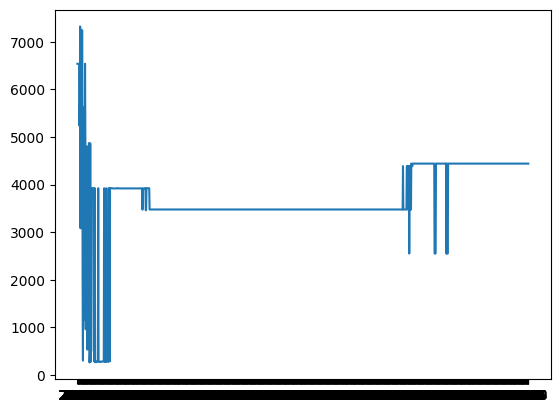

In [ ]:
schluessel_id = list(id_werte.keys())
werte_id = list(id_werte.values())
plt.plot(schluessel_id, werte_id)

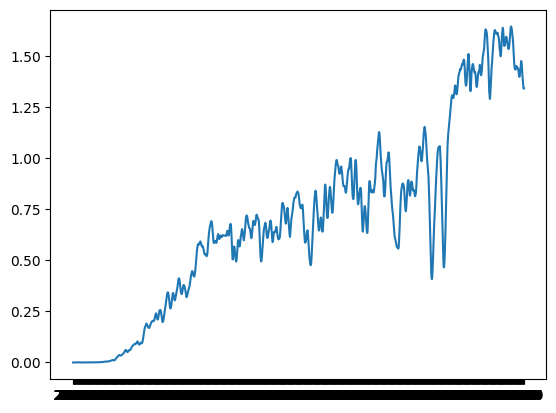

In [ ]:
# Plotten der maximalen Werte nach Wellenlänge
schluessel_max = list(max_werte.keys())
werte_max = list(max_werte.values())
plt.plot(schluessel_max, werte_max)

## Abspeichern der spektralen Messwerte in einen Dataframe:

In [ ]:
save_dataframe_to_drive(df_Messdaten_inter, '/content/drive/My Drive/Colab_Notebooks/CSV_Messdaten', month)

Der DataFrame wurde als 23.08 in /content/drive/My Drive/Colab_Notebooks/CSV_Messdaten auf Google Drive gespeichert.
